# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
# from tqdm import tqdm
# import concurrent.futures

import sys
sys.path.append('../')

from src.config import *
from src.helper_visualization import *
# from src.helper_text import *
# from src.helper_langID import *
# from src.helper_translation import *
from src.helper_pred import *

# Prepare Data

## Load Cleaned Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160696 entries, 0 to 160695
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        160696 non-null  int64 
 1   Title             160696 non-null  object
 2   Product Name      160696 non-null  object
 3   Length            160696 non-null  int64 
 4   Language          160696 non-null  object
 5   Title_Processed   160696 non-null  object
 6   Title_Translated  160696 non-null  object
 7   Title_Cleaned     160696 non-null  object
dtypes: int64(2), object(6)
memory usage: 9.8+ MB
None


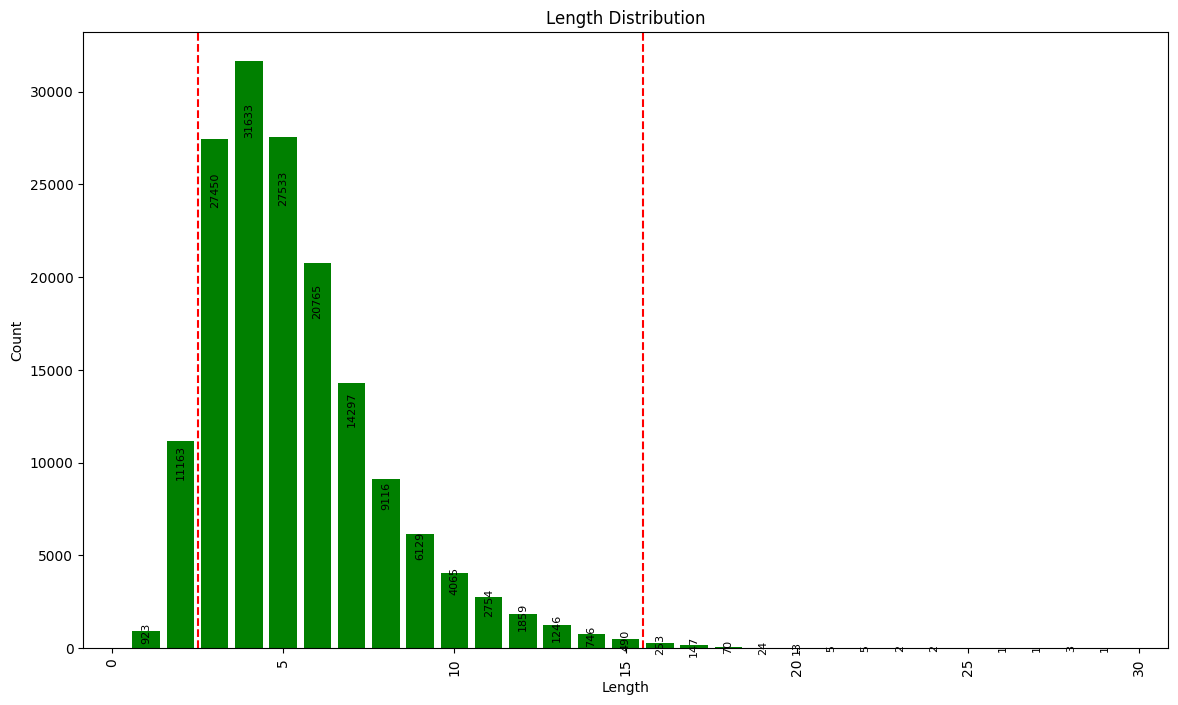

In [2]:
# excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_cleaned.xlsx'
excel_file = f'{DATA_FOLDER_PATH_PROCESSED}/data_augmented.xlsx'
df_cleaned = pd.read_excel(excel_file)
print(df_cleaned.info())
hist_by_labels(df_cleaned, 'Length', log=False, left=2.5, right=15.5)
# plot a square in red color on the histogram

## Remove short Titles

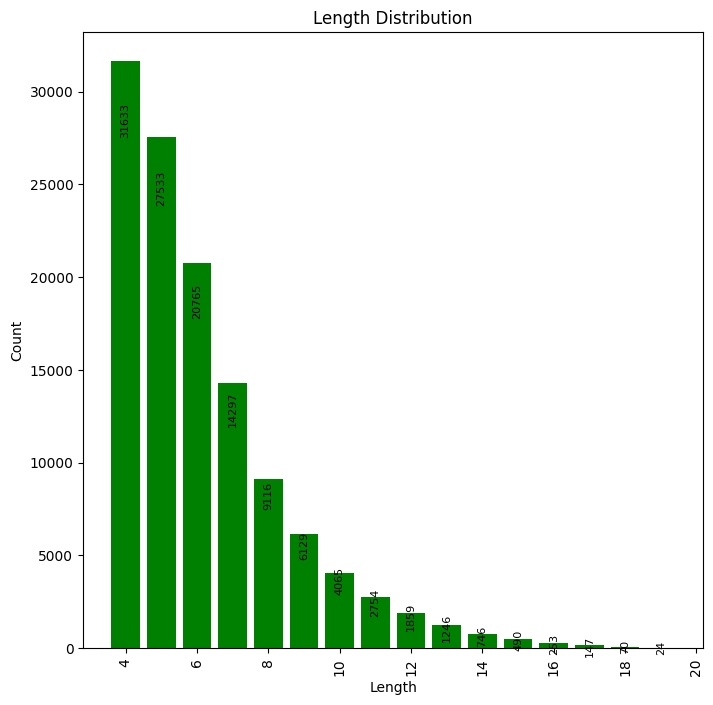

In [3]:
# filter out the titles with length less than 3 and more than 20
# when the title is too short, it is either not useful or it is too obvious to be classified
mask = (df_cleaned['Length'] > 3) & (df_cleaned['Length'] < 20)
df_cleaned = df_cleaned[mask]
hist_by_labels(df_cleaned, 'Length', horizontal=True)

## Combine the long tail into Others

In [ ]:
hist_by_labels(df_cleaned, 'Product Name', top=None, log=True, horizontal=True)
hist_by_labels(df_cleaned, 'Product Name', top=30, log=True, horizontal=True)

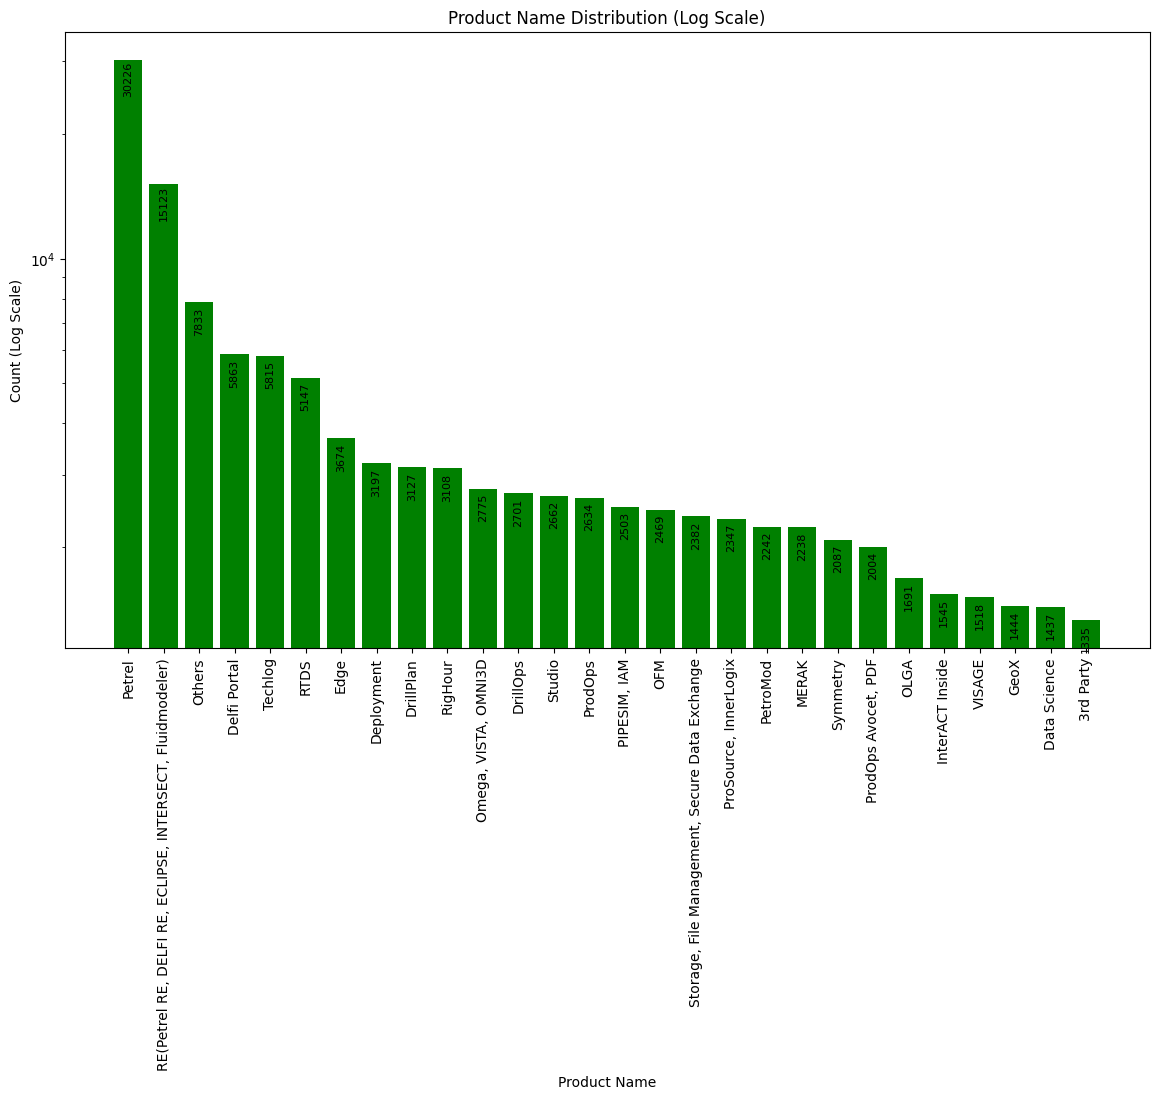

In [4]:
# Keep the top 50 products and combine the rest into 'Others'
product_counts = df_cleaned['Product Name'].value_counts()
cutoff = 1000
product_top = product_counts.index[product_counts >= cutoff]
product_others = product_counts.index[product_counts < cutoff]

mask_others = df_cleaned['Product Name'].isin(product_others)
df_cleaned.loc[mask_others,'Product Name']='Others'
hist_by_labels(df_cleaned, 'Product Name', log=True)

## Train/Test Split

<class 'pandas.core.frame.DataFrame'>
Index: 70897 entries, 102726 to 153108
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        70897 non-null  int64 
 1   Title             70897 non-null  object
 2   Product Name      70897 non-null  object
 3   Length            70897 non-null  int64 
 4   Language          70897 non-null  object
 5   Title_Processed   70897 non-null  object
 6   Title_Translated  70897 non-null  object
 7   Title_Cleaned     70897 non-null  object
dtypes: int64(2), object(6)
memory usage: 4.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 50230 entries, 1 to 153203
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        50230 non-null  int64 
 1   Title             50230 non-null  object
 2   Product Name      50230 non-null  object
 3   Length            50230 non-null  int

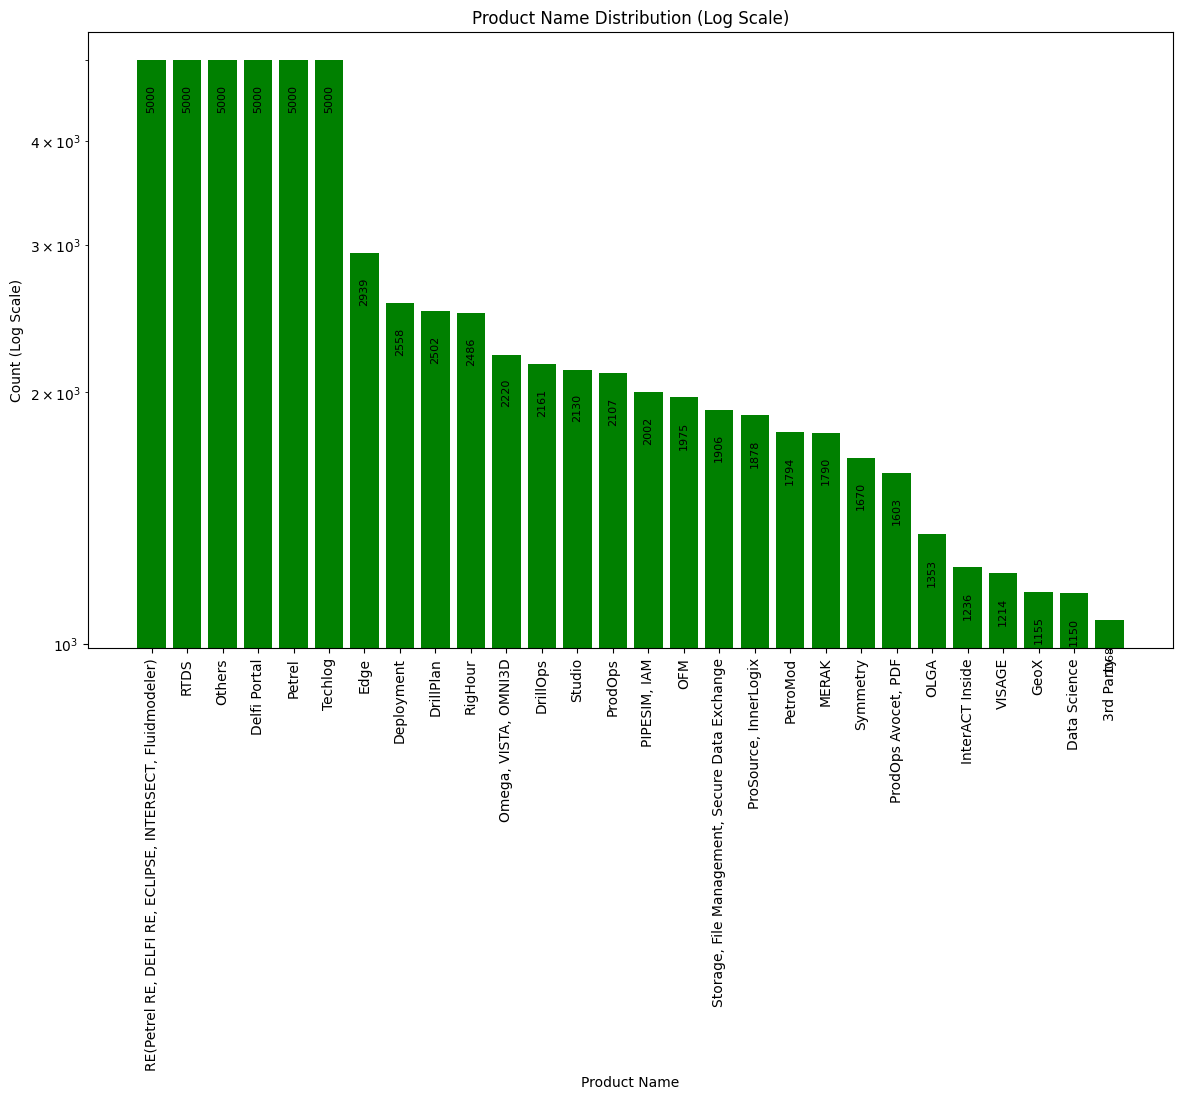

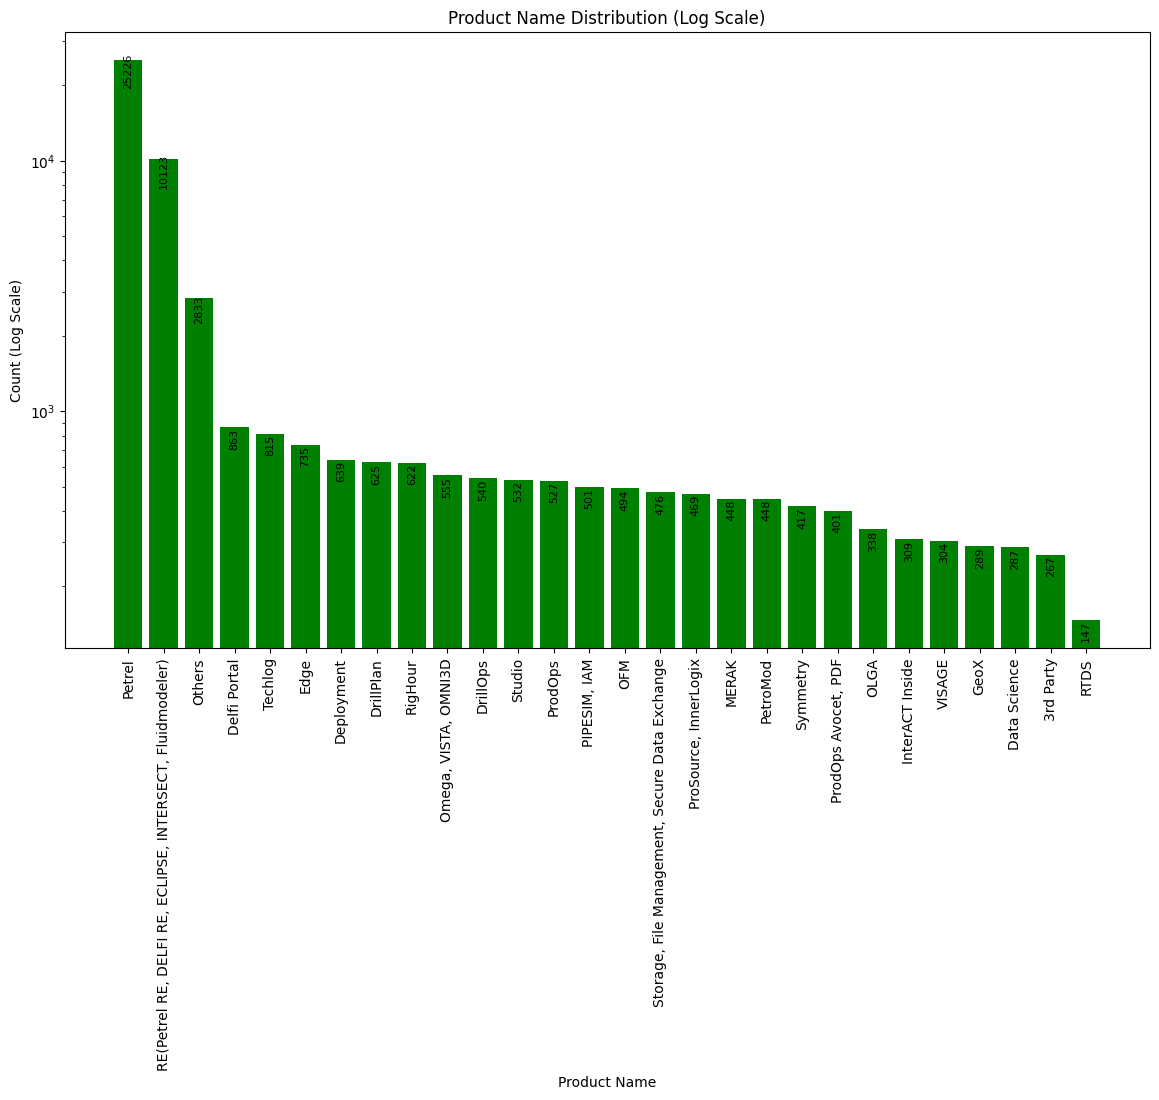

In [5]:
# for the products with more than 5000 records, randomly select 4000 records for each product and put in a new dataframe df_cleaned_balanced, then keep the rest of the records in df_cleaned_test
df_cleaned_balanced = pd.DataFrame()
df_cleaned_test = pd.DataFrame()
for product in df_cleaned['Product Name'].unique():
    df_product = df_cleaned[df_cleaned['Product Name'] == product]
    if df_product.shape[0] > 5000:
        df_product_balanced = df_product.sample(5000).copy()
        df_cleaned_balanced = pd.concat([df_cleaned_balanced, df_product_balanced])
        df_product_test = df_product.drop(df_product_balanced.index)
        df_cleaned_test = pd.concat([df_cleaned_test, df_product_test])
    else:
        df_product_balanced = df_product.sample(frac=0.8).copy()
        df_cleaned_balanced = pd.concat([df_cleaned_balanced, df_product_balanced])
        df_product_test = df_product.drop(df_product_balanced.index)
        df_cleaned_test = pd.concat([df_cleaned_test, df_product_test])

print(df_cleaned_balanced.info())
print(df_cleaned_test.info())

hist_by_labels(df_cleaned_balanced, 'Product Name', log=True)
hist_by_labels(df_cleaned_test, 'Product Name', log=True)

In [6]:
# Prepare data for training and testing for 
# a. cross validation
# b. logistic regression, 
# c. SGC Classifier

#import packages related to data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer

X = df_cleaned['Title_Cleaned']
vectorizer = CountVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2))
vectorizer.fit(X)

X_train = df_cleaned_balanced['Title_Cleaned']
X_train_encoded = vectorizer.transform(X_train)
y_train = df_cleaned_balanced['Product Name']

X_test = df_cleaned_test['Title_Cleaned']
X_test_encoded = vectorizer.transform(X_test)
y_test = df_cleaned_test['Product Name']

# Train Models

## Model Baseline - Cross Validation

In [7]:
# Model Tuning
from sklearn.model_selection import cross_validate

# Models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# import xgboost as xgb

import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [8]:
models = {
    'SVC linear': SVC(kernel='linear'),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'SVC rbf': SVC(kernel='rbf'),
    'MultinomialNB': MultinomialNB(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'XGBClassifier': xgb.XGBClassifier()
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded, # please provide the features after preprocessing
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.8558 by SVC linear.
Average score: 0.8553 by LogisticRegression.
Average score: 0.8504 by SGDClassifier.
Average score: 0.8450 by SVC rbf.
Average score: 0.8142 by MultinomialNB.


In [ ]:
# Baseline Score(s) of each model are ....
# Average score: 0.8570 by SVC linear.
# Average score: 0.8558 by LogisticRegression.
# Average score: 0.8534 by SGDClassifier.
# Average score: 0.8475 by SVC rbf.
# Average score: 0.8183 by MultinomialNB.

## Hpyerparameter Tuning

## SGC Classifier

In [9]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-20 23:25:06,595] A new study created in memory with name: no-name-c9cba48e-dbdb-467e-aec9-450ab22837e0


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-10-20 23:25:12,970] Trial 9 finished with value: 0.8276231929239202 and parameters: {'loss': 'modified_huber', 'alpha': 0.001167875470358449, 'penalty': 'l2'}. Best is trial 9 with value: 0.8276231929239202.
[I 2023-10-20 23:25:15,618] Trial 5 finished with value: 0.37904258477967223 and parameters: {'loss': 'log_loss', 'alpha': 1.2675171914622476, 'penalty': 'l2'}. Best is trial 9 with value: 0.8276231929239202.
[I 2023-10-20 23:25:16,726] Trial 7 finished with value: 0.7376616096571431 and parameters: {'loss': 'log_loss', 'alpha': 0.0009044915217222481, 'penalty': 'l2'}. Best is trial 9 with value: 0.8276231929239202.
[I 2023-10-20 23:25:17,561] Trial 3 finished with value: 0.0705248459873961 and parameters: {'loss': 'log_loss', 'alpha': 9.905667117946667, 'penalty': 'l1'}. Best is trial 9 with value: 0.8276231929239202.
[I 2023-10-20 23:25:21,526] Trial 8 finished with value: 0.47691651005365515 and parameters: {'loss': 'log_loss', 'alpha': 0.2301977547871774, 'penalty': 'l2

                                                           precision    recall  f1-score   support

                                                3rd Party      0.563     0.820     0.668       267
                                             Data Science      0.925     0.941     0.933       287
                                             Delfi Portal      0.247     0.693     0.364       863
                                               Deployment      0.729     0.782     0.755       639
                                                 DrillOps      0.950     0.959     0.955       540
                                                DrillPlan      0.700     0.843     0.765       625
                                                     Edge      0.997     0.986     0.992       735
                                                     GeoX      0.831     0.969     0.895       289
                                          InterACT Inside      0.950     0.981     0.965       309
         

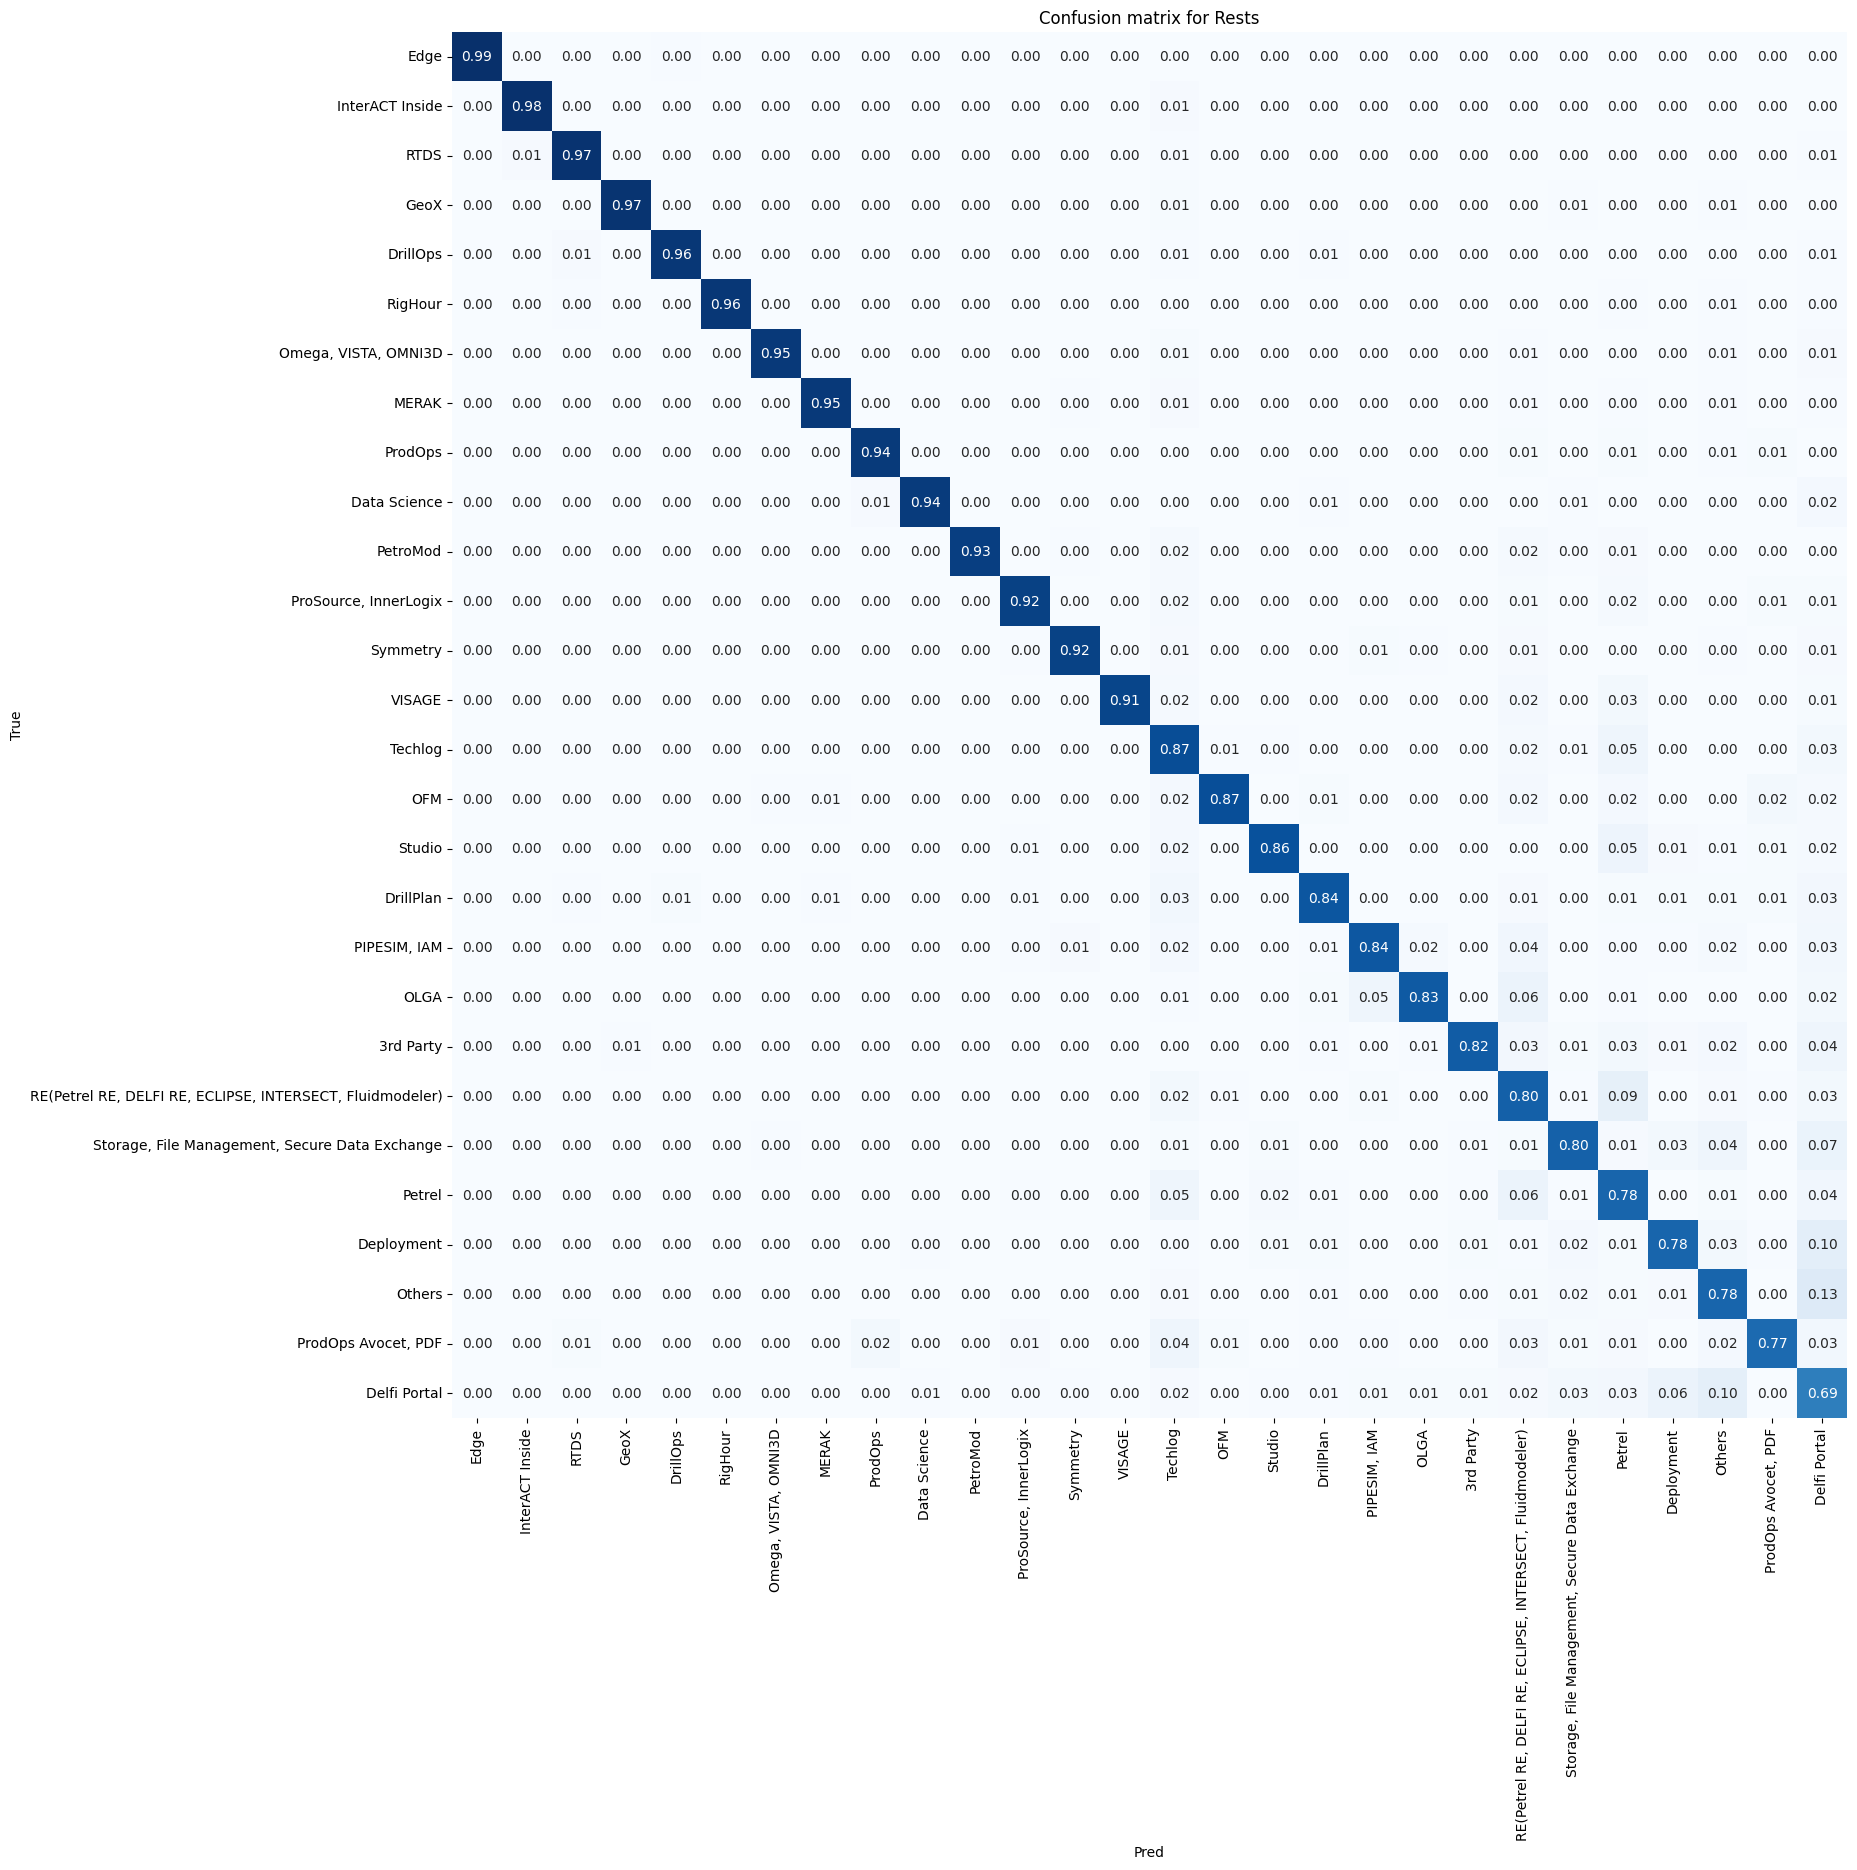

Accuracy of top 1 prediction is 0.811.
Accuracy of top 3 prediction is 0.949.
Accuracy of top 5 prediction is 0.974.


In [10]:
# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)
# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))


## Logistic Classification

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# Create and train the best Logistic Regression model
model_logReg= LogisticRegression(max_iter=5000)
model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(model_logReg, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# export the model
import pickle
pickle.dump(model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))

# export the vectorizer
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB

In [ ]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=300, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear

In [ ]:
# user Optuna to tune the hyperparameters for SVC Linear

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1e-6, 1e+2, log=True),
        'max_iter': 5000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f"Accuracy: {accuracy:.3f}")

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer, X_test, y_test, pre_processed=True)

In [ ]:

pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
